<a href="https://colab.research.google.com/github/MittalNeha/Extensive_Vision_AI6/blob/main/week4/Experiments/Session_4_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 4
##  Training MNIST (Experiment model_2)
Training Accuracy(loss) :     99.22% (0.024154)

Testing Accuracy (loss) :     99.46% (0.018882)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Model Architecture
10->20->30->MP->10->10->20->MP-> 10 -> 10 -> 20 ->GAP->Dense->10

In [3]:
drop_out_val = 0.05
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # CONVOLUTION LAYER 1                     
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), padding=1)      
        self.bn1 = nn.BatchNorm2d(10)
        self.do1 = nn.Dropout2d(drop_out_val)
        
        # CONVOLUTION LAYER 2
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(20)
        self.do2 = nn.Dropout2d(drop_out_val)
        
        # CONVOLUTION LAYER 3
        self.conv3  = nn.Conv2d(20, 30, 3, padding=1)
        self.bn3    = nn.BatchNorm2d(30)
        self.do3    = nn.Dropout2d(drop_out_val)

        # TRANSITION LAYER 1
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv_t1 = nn.Conv2d(30, 10, 1)
        self.bn_t1 = nn.BatchNorm2d(10)
        self.do_t1 = nn.Dropout2d(drop_out_val)

        # CONVOLUTION LAYER 4
        self.conv4 = nn.Conv2d(10, 10, 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(10)
        self.do4 = nn.Dropout2d(drop_out_val)

        # CONVOLUTION LAYER 5
        self.conv5  = nn.Conv2d(10, 20, 3, padding = 1)
        self.bn5    = nn.BatchNorm2d(20)
        self.do5    = nn.Dropout2d(drop_out_val)


        # TRANSITION LAYER 2
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv_t2  = nn.Conv2d(20, 10, 1)
        self.bn_t2    = nn.BatchNorm2d(10)
        self.do_t2    = nn.Dropout2d(drop_out_val)

        # CONVOLUTION LAYER 6
        self.conv6 = nn.Conv2d(10, 10, 3, padding = 1)
        self.bn6 = nn.BatchNorm2d(10)
        self.do6 = nn.Dropout2d(drop_out_val)

        # CONVOLUTION LAYER 7
        self.conv7 = nn.Conv2d(10, 20, 3, padding = 1)

        self.gap = nn.AvgPool2d(7)
        self.linear1 = nn.Linear(20, 10)

    def forward(self, x):
        #BN after Relu
        x = self.pool1(self.do3(self.bn3(F.relu(self.conv3  (self.do2(self.bn2(F.relu(self.conv2  (self.do1(self.bn1(F.relu(self.conv1(x)))))  )))) ))))  
        x = self.pool2(self.do5(self.bn5(F.relu(self.conv5  (self.do4(self.bn4(F.relu(self.conv4  (self.do_t1(self.bn_t1(F.relu(self.conv_t1(x)))))  ))))  )))) 
        x =                       F.relu( self.conv7        (self.do6(self.bn6(F.relu(self.conv6  (self.do_t2(self.bn_t2(F.relu(self.conv_t2(x)))))  ))))  )               
        
        x = self.gap(x)
        x = x.view(-1, 20)
        x = self.linear1(x)

        return F.log_softmax(x)       #log of softmax

model = Net().to(device)

In [4]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
         Dropout2d-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 20, 28, 28]           1,820
       BatchNorm2d-5           [-1, 20, 28, 28]              40
         Dropout2d-6           [-1, 20, 28, 28]               0
            Conv2d-7           [-1, 30, 28, 28]           5,430
       BatchNorm2d-8           [-1, 30, 28, 28]              60
         Dropout2d-9           [-1, 30, 28, 28]               0
        MaxPool2d-10           [-1, 30, 14, 14]               0
           Conv2d-11           [-1, 10, 14, 14]             310
      BatchNorm2d-12           [-1, 10, 14, 14]              20
        Dropout2d-13           [-1, 10, 14, 14]               0
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


##Download the dataset


In [5]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


## Utility Functions

In [6]:
# from tqdm.notebook import tqdm

#Use scheduler
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    # pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    num_loops = 0
    # for batch_idx, (data, target) in enumerate(pbar):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        num_loops +=1

    
    train_loss /= num_loops
    # scheduler.step()
    scheduler.step(train_loss)
    hist_train_loss.append(train_loss)
    hist_train_acc.append(100. * correct / len(train_loader.dataset))
    print("Training Average loss: {:.6f}, Accuracy = ({:.6f}%)".format(train_loss, 100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    hist_test_loss.append(test_loss)
    hist_test_acc.append(100. * correct / len(test_loader.dataset))

    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
def draw_network(model):
  model = model.to("cpu")
  hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))
  # Use a different color theme
  hl_graph.theme = hl.graph.THEMES["blue"].copy()
  return hl_graph

In [8]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(hist_test_acc))
  plt.plot(np.array(hist_train_acc), 'r')
  plt.legend(["test_acc", "train_acc"])
  plt.title("Accuracy per epoch")

  plt.subplot(1,2,2)
  plt.plot(hist_test_loss)
  plt.plot(hist_train_loss, 'r')
  plt.legend(["test_loss", "train_loss"])
  plt.title("Loss per epoch")


## Summary and training

In [13]:
#reset the Network
model = Net().to(device)

In [14]:
hist_test_loss = []
hist_test_acc = []
hist_train_loss = []
hist_train_acc = []

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR

Learning Rate going from 0.1 to 0.05 to 0.01

Epoch:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


938
Training Average loss: 0.358030, Accuracy = (88.233333%)
learning rate 0.1
Test set: Average loss: 0.081678, Accuracy: 9738/10000 (97.380000%)

Epoch:  2
938
Training Average loss: 0.121910, Accuracy = (96.306667%)
learning rate 0.1
Test set: Average loss: 0.048680, Accuracy: 9844/10000 (98.440000%)

Epoch:  3
938
Training Average loss: 0.089770, Accuracy = (97.338333%)
learning rate 0.1
Test set: Average loss: 0.041105, Accuracy: 9868/10000 (98.680000%)

Epoch:  4
938
Training Average loss: 0.076718, Accuracy = (97.735000%)
learning rate 0.1
Test set: Average loss: 0.039886, Accuracy: 9875/10000 (98.750000%)

Epoch:  5
938
Training Average loss: 0.071120, Accuracy = (97.836667%)
learning rate 0.1
Test set: Average loss: 0.043493, Accuracy: 9862/10000 (98.620000%)

Epoch:  6
938
Training Average loss: 0.062978, Accuracy = (98.131667%)
learning rate 0.1
Test set: Average loss: 0.032777, Accuracy: 9898/10000 (98.980000%)

Epoch:  7
938
Training Average loss: 0.061220, Accuracy = (98.

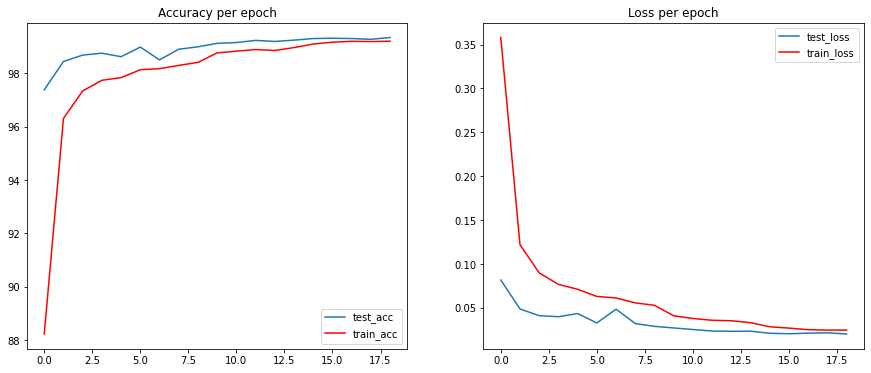

In [15]:
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,)

scheduler =ReduceLROnPlateau(optimizer=optimizer, patience=2, verbose=True)

for epoch in range(1, 10):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
for epoch in range(10, 15):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(15, 20):
    print("Epoch: ", epoch)
    train(model, device, train_loader, optimizer, scheduler, epoch)
    print("learning rate", optimizer.param_groups[0]['lr'])
    test(model, device, test_loader)

training_curves()